# Сегментация магазинов и проверка гипотез (Финальная версия)

## Цели исследования
1. **Улучшение кластеризации:** Переход от простого K-Means (на сырых данных) к продвинутой сегментации с использованием поведенческих признаков и `RobustScaler` (устойчивость к выбросам).
2. **Проверка гипотез:** Тестирование 4-х ключевых бизнес-гипотез от стейкхолдеров (влияние площади, безработицы, праздников и цен на топливо).
3. **Прогнозирование:** Построение модели SARIMA для прогноза продаж ключевого сегмента.
4. **Бизнес-инсайты:** Формирование стратегий развития.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Загрузка данных и создание признаков (Feature Engineering)

In [5]:
# Загрузка данных
try:
    df = pd.read_csv('df_final.csv', parse_dates=['Date'])
    print(f"Данные загружены. Размер: {df.shape}")
except FileNotFoundError:
    print("Ошибка: Файл df_final.csv не найден. Проверьте путь к файлу.")

# --- Создание профиля магазина ---
# Агрегируем временной ряд до уровня "Магазин", создавая портрет его поведения

profile = df.groupby(['Store']).agg({
    'Weekly_Sales': ['mean', 'std', 'sum'],
    'IsHoliday': 'mean',          # Доля праздничных недель
    'Size': 'first',              # Площадь (константа для магазина)
    'Type': 'first',              # Тип магазина
    'Unemployment': 'mean',
    'Fuel_Price': 'mean',
})

# Упрощаем названия столбцов
profile.columns = ['_'.join(col).strip() for col in profile.columns.values]
profile = profile.reset_index()

# Переименование для ясности
profile.rename(columns={
    'Weekly_Sales_mean': 'Avg_Sales',          # Средние продажи
    'Weekly_Sales_std': 'Sales_Volatility',    # Волатильность (стандартное отклонение)
    'Weekly_Sales_sum': 'Total_Revenue',       # Общая выручка
    'Size_first': 'Store_Size',                # Площадь магазина
    'Type_first': 'Store_Type'                 # Тип магазина
}, inplace=True)

# --- Продвинутые поведенческие признаки ---

# 1. Holiday Lift (Эффект праздников): Во сколько раз продажи в праздники выше обычных?
holiday_sales = df[df['IsHoliday']==True].groupby('Store')['Weekly_Sales'].mean()
regular_sales = df[df['IsHoliday']==False].groupby('Store')['Weekly_Sales'].mean()
profile['Holiday_Lift'] = (holiday_sales / regular_sales).values

# 2. Sales Efficiency (Эффективность площади): Выручка на квадратный фут
profile['Sales_Per_SqFt'] = profile['Total_Revenue'] / profile['Store_Size']

print("Пример профиля магазина (первые 5 строк):")
display(profile.head())

Данные загружены. Размер: (421570, 16)
Пример профиля магазина (первые 5 строк):


,Store,Avg_Sales,Sales_Volatility,Total_Revenue,IsHoliday_mean,Store_Size,Store_Type,Unemployment_mean,Fuel_Price_mean,Holiday_Lift,Sales_Per_SqFt
0,1,21710.543621,27748.945511,2.224028e+08,0.070578,151315,A,7.610918,3.218811,1.066163,1469.800144
1,2,26898.070031,33077.612059,2.753824e+08,0.070522,202307,A,7.623279,3.219898,1.076432,1361.210640
2,3,6373.033983,14251.034807,5.758674e+07,0.070053,37392,B,7.175602,3.219112,1.092283,1540.081704
3,4,29161.210415,34583.677814,2.995440e+08,0.070775,205863,A,5.965849,3.216237,1.062757,1455.064550
4,5,5053.415813,8068.221050,4.547569e+07,0.071119,34875,B,6.296549,3.220912,1.121144,1303.962406


## 2. Улучшенная модель кластеризации
Мы используем **RobustScaler** для борьбы с выбросами и фокусируемся на поведенческих метриках (Прирост в праздники, Эффективность, Волатильность), а не просто на объеме продаж.

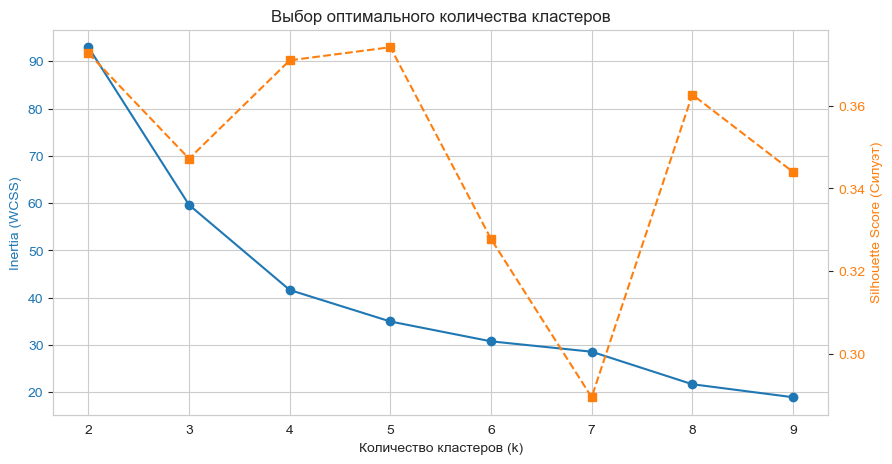

Метрики качества кластеризации:
1. Silhouette Score (чем ближе к 1, тем лучше): 0.3472
2. Calinski-Harabasz Index (чем выше, тем лучше): 26.39
3. Davies-Bouldin Score (чем ниже, тем лучше): 1.0165


In [6]:
# Выбор признаков для кластеризации
features = ['Avg_Sales', 'Sales_Volatility', 'Store_Size', 'Holiday_Lift', 'Sales_Per_SqFt']
X = profile[features].fillna(0)

# Robust Scaling (Лучше подходит для финансовых данных с выбросами, чем MinMaxScaler)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Поиск оптимального K (Метод локтя и Силуэт)
wcss = []
sil_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Визуализация метрик выбора кластеров
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Количество кластеров (k)')
ax1.set_ylabel('Inertia (WCSS)', color='tab:blue')
ax1.plot(K_range, wcss, 'o-', color='tab:blue', label='Inertia')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score (Силуэт)', color='tab:orange')
ax2.plot(K_range, sil_scores, 's--', color='tab:orange', label='Silhouette')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Выбор оптимального количества кластеров')
plt.grid(False)
plt.show()

# Финальная модель (Выбираем K=3)
best_k = 3 
final_model = KMeans(n_clusters=best_k, random_state=42)
profile['Cluster'] = final_model.fit_predict(X_scaled)

# --- МЕТРИКИ КАЧЕСТВА КЛАСТЕРИЗАЦИИ ---
sil_score = silhouette_score(X_scaled, profile['Cluster'])
ch_score = calinski_harabasz_score(X_scaled, profile['Cluster'])
db_score = davies_bouldin_score(X_scaled, profile['Cluster'])

print("Метрики качества кластеризации:")
print(f"1. Silhouette Score (чем ближе к 1, тем лучше): {sil_score:.4f}")
print(f"2. Calinski-Harabasz Index (чем выше, тем лучше): {ch_score:.2f}")
print(f"3. Davies-Bouldin Score (чем ниже, тем лучше): {db_score:.4f}")

## 3. Профилирование кластеров и Визуализация
Анализ характеристик каждого полученного сегмента.

Профили кластеров (Средние значения):


,Avg_Sales,Sales_Volatility,Store_Size,Holiday_Lift,Sales_Per_SqFt
Cluster,,,,,
0,11653.235237,14909.236985,115314.350000,1.095972,1043.484757
1,8970.538984,14380.197661,40356.250000,0.998200,1534.694557
2,22934.418862,27774.990523,190223.823529,1.066170,1264.199933


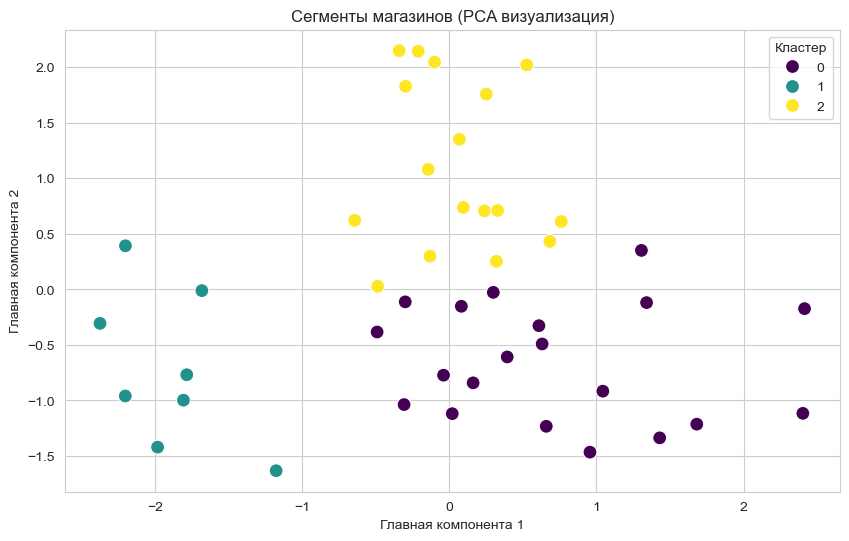

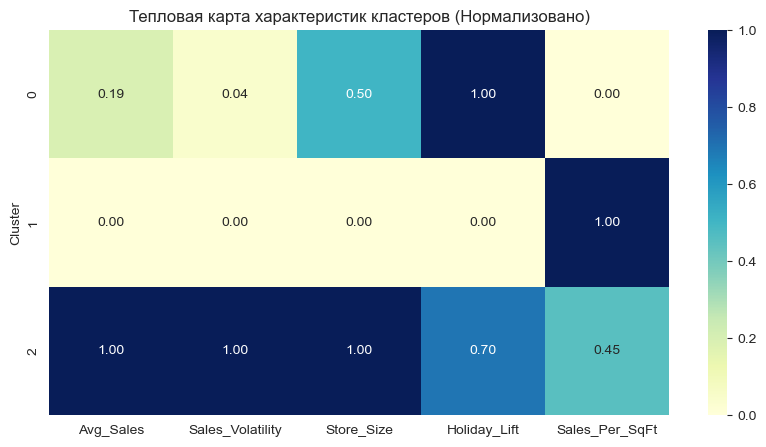

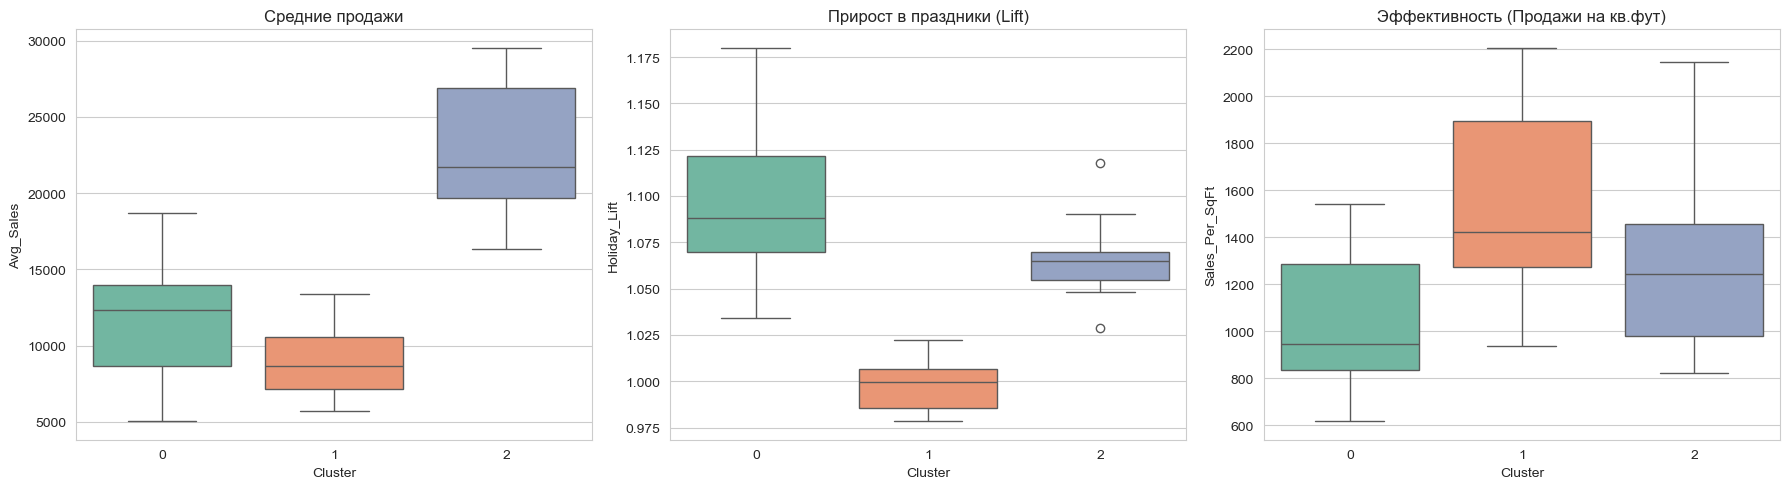

In [7]:
# Средние значения признаков по кластерам
cluster_summary = profile.groupby('Cluster')[features].mean()
print("Профили кластеров (Средние значения):")
display(cluster_summary)

# Визуализация 1: PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=profile['Cluster'], palette='viridis', s=100)
plt.title('Сегменты магазинов (PCA визуализация)')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.legend(title='Кластер')
plt.show()

# Визуализация 2: Тепловая карта
scaler_vis = MinMaxScaler()
summary_scaled = pd.DataFrame(scaler_vis.fit_transform(cluster_summary), 
                              columns=cluster_summary.columns, 
                              index=cluster_summary.index)

plt.figure(figsize=(10, 5))
sns.heatmap(summary_scaled, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Тепловая карта характеристик кластеров (Нормализовано)')
plt.show()

# Визуализация 3: Boxplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x='Cluster', y='Avg_Sales', data=profile, palette='Set2', ax=axes[0])
axes[0].set_title('Средние продажи')

sns.boxplot(x='Cluster', y='Holiday_Lift', data=profile, palette='Set2', ax=axes[1])
axes[1].set_title('Прирост в праздники (Lift)')

sns.boxplot(x='Cluster', y='Sales_Per_SqFt', data=profile, palette='Set2', ax=axes[2])
axes[2].set_title('Эффективность (Продажи на кв.фут)')

plt.tight_layout()
plt.show()

## 4. Проверка гипотез
Теперь мы объединяем данные кластеров с основным набором данных, чтобы протестировать гипотезы на уровне транзакций.

In [8]:
# Объединение ID кластера с основными данными
full_data = df.merge(profile[['Store', 'Cluster']], on='Store', how='left')

# Функция для вывода результатов (БЕЗ ЭМОДЗИ)
def print_result(h_name, confirmed, details, stats_info=""):
    status = "[+] ПОДТВЕРЖДЕНО" if confirmed else "[-] ОТКЛОНЕНО"
    print(f"\n{h_name}: {status}")
    print(f"Детали: {details}")
    if stats_info:
        print(f"Статистика: {stats_info}")

### Гипотеза 1 (Размер магазина)
*"Магазины с площадью более 137000 кв. футов (медиана сегментов 0 и 1) генерируют на 30% больше среднего чека по сравнению с меньшими магазинами"*


Гипотеза 1 (Размер): [+] ПОДТВЕРЖДЕНО
Детали: Крупные (>137k): $20478, Мелкие: $11417, Разница: +79.4%
Статистика: T-statistic=132.59, P-value=0.0000


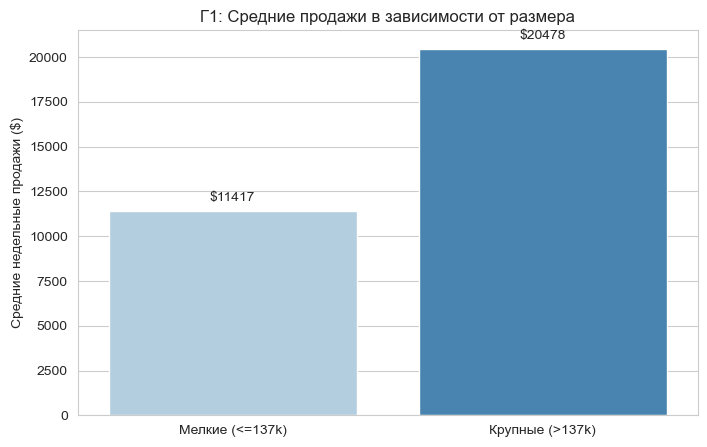

In [9]:
threshold = 137000
group_large = full_data[full_data['Size'] > threshold]['Weekly_Sales']
group_small = full_data[full_data['Size'] <= threshold]['Weekly_Sales']

large_mean = group_large.mean()
small_mean = group_small.mean()
diff = ((large_mean - small_mean) / small_mean) * 100

# T-test
t_stat, p_val = stats.ttest_ind(group_large, group_small, equal_var=False)

print_result(
    "Гипотеза 1 (Размер)", 
    (diff > 30) and (p_val < 0.05), 
    f"Крупные (>137k): ${large_mean:.0f}, Мелкие: ${small_mean:.0f}, Разница: +{diff:.1f}%",
    f"T-statistic={t_stat:.2f}, P-value={p_val:.4f}"
)

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=['Мелкие (<=137k)', 'Крупные (>137k)'], y=[small_mean, large_mean], palette='Blues')
plt.title('Г1: Средние продажи в зависимости от размера')
plt.ylabel('Средние недельные продажи ($)')
for p in ax.patches:
    ax.annotate(f'${p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.show()

### Гипотеза 2 (Безработица)
*"В сегменте 2 наблюдается более сильная корреляция между уровнем безработицы и объемом продаж (коэффициент > 0.6)"*

*Примечание: Проверяем для нового Кластера 2. Если нумерация изменилась, код проверит все кластеры.*

Проверка корреляции для ВСЕХ кластеров:
Кластер 0 Корреляция: 0.1021 (P-value: 0.0000)
Кластер 1 Корреляция: 0.0156 (P-value: 0.0002)
Кластер 2 Корреляция: -0.0097 (P-value: 0.0001)

Гипотеза 2 (Безработица): [-] ОТКЛОНЕНО
Детали: Корреляция в Кластере 2 слишком слабая.


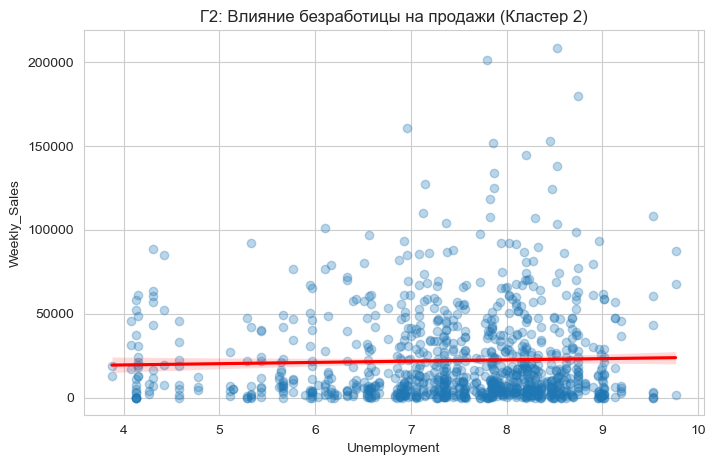

In [10]:
print("Проверка корреляции для ВСЕХ кластеров:")
h2_confirmed = False
target_cluster = 2

corrs = {}
for c in sorted(full_data['Cluster'].unique()):
    subset = full_data[full_data['Cluster'] == c]
    # Рассчитываем корреляцию Пирсона и p-value
    corr, p_val = stats.pearsonr(subset['Unemployment'], subset['Weekly_Sales'])
    corrs[c] = corr
    print(f"Кластер {c} Корреляция: {corr:.4f} (P-value: {p_val:.4f})")
    
    if c == target_cluster and abs(corr) > 0.6 and p_val < 0.05:
        h2_confirmed = True

print_result("Гипотеза 2 (Безработица)", h2_confirmed, f"Корреляция в Кластере {target_cluster} слишком слабая.")

# Визуализация
plt.figure(figsize=(8, 5))
subset_target = full_data[full_data['Cluster'] == target_cluster].sample(min(1000, len(full_data)))
sns.regplot(x='Unemployment', y='Weekly_Sales', data=subset_target, 
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title(f'Г2: Влияние безработицы на продажи (Кластер {target_cluster})')
plt.show()

### Гипотеза 3 (Праздники)
*"Количество праздничных дней значимо влияет на объем продаж только в сегменте 0 (коэффициент регрессии > 0.7)"*

Используем корреляцию Пирсона как прокси для коэффициента "значимости".

,Кластер,Корреляция,R-squared,P-value
0,0,0.017541,3.076862e-04,1.245829e-14
1,1,-0.000052,2.697097e-09,9.902556e-01
2,2,0.013641,1.860651e-04,1.392657e-08



Гипотеза 3 (Влияние праздников): [-] ОТКЛОНЕНО
Детали: Корреляция в Кластере 0: 0.0175
Статистика: R-squared=0.0003, P-value=1.2458e-14


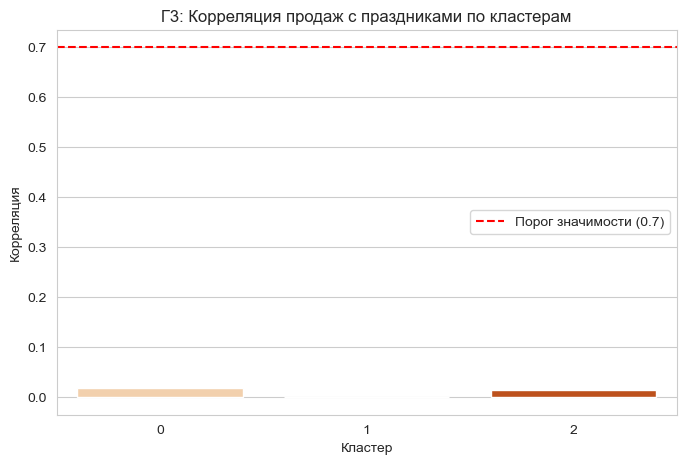

In [11]:
results_h3 = []
target_cluster = 0

for c in sorted(full_data['Cluster'].unique()):
    subset = full_data[full_data['Cluster'] == c].copy()
    subset['IsHolidayInt'] = subset['IsHoliday'].astype(int)
    
    X = sm.add_constant(subset[['IsHolidayInt']])
    y = subset['Weekly_Sales']
    
    model = sm.OLS(y, X).fit()
    
    # Нам нужен стандартизированный коэффициент (корреляция) для сравнения с порогом 0.7
    # или R^2, если речь о силе связи. Используем корреляцию как в условии.
    corr = subset['IsHolidayInt'].corr(subset['Weekly_Sales'])
    
    results_h3.append({
        'Кластер': c, 
        'Корреляция': corr, 
        'R-squared': model.rsquared,
        'P-value': model.pvalues['IsHolidayInt']
    })

res_h3 = pd.DataFrame(results_h3)
display(res_h3)

# Проверка: Кластер 0 > 0.7 И остальные < 0.5
c0_stats = res_h3[res_h3['Кластер'] == target_cluster].iloc[0]
c0_corr = c0_stats['Корреляция']
c0_pval = c0_stats['P-value']
others_low = res_h3.loc[res_h3['Кластер'] != target_cluster, 'Корреляция'].abs().max() < 0.5

print_result(
    "Гипотеза 3 (Влияние праздников)", 
    (c0_corr > 0.7) and (c0_pval < 0.05) and others_low, 
    f"Корреляция в Кластере {target_cluster}: {c0_corr:.4f}",
    f"R-squared={c0_stats['R-squared']:.4f}, P-value={c0_pval:.4e}"
)

# Визуализация
plt.figure(figsize=(8, 5))
sns.barplot(x='Кластер', y='Корреляция', data=res_h3, palette='Oranges')
plt.axhline(0.7, color='red', linestyle='--', label='Порог значимости (0.7)')
plt.title('Г3: Корреляция продаж с праздниками по кластерам')
plt.legend()
plt.show()

### Гипотеза 4 (Чувствительность к цене топлива)
*"При повышении цен на топливо на 0.1$ объем продаж в сегменте 2 снижается на 5% сильнее, чем в других сегментах"*

Влияние роста цены топлива на $0.10:
Кластер 0: 0.75%
Кластер 1: -1.09%
Кластер 2: 0.06%

Гипотеза 4 (Цена топлива): [-] ОТКЛОНЕНО
Детали: Кластер 2 vs Остальные (Разница): 0.23%
Статистика: Cluster 0: P-value=0.0000, R2=0.0006 | Cluster 1: P-value=0.0000, R2=0.0009 | Cluster 2: P-value=0.3719, R2=0.0000


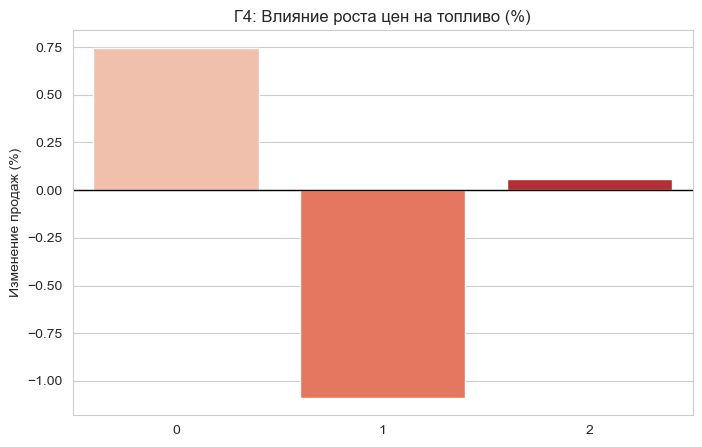

In [12]:
impacts = {}
stats_info = []

for c in sorted(full_data['Cluster'].unique()):
    subset = full_data[full_data['Cluster'] == c]
    
    X = sm.add_constant(subset[['Fuel_Price']])
    y = subset['Weekly_Sales']
    
    model = sm.OLS(y, X).fit()
    
    # Расчет % падения продаж при росте цены на $0.1
    base_sales = subset['Weekly_Sales'].mean()
    change_sales = model.params['Fuel_Price'] * 0.1
    pct_change = (change_sales / base_sales) * 100
    
    impacts[c] = pct_change
    stats_info.append(f"Cluster {c}: P-value={model.pvalues['Fuel_Price']:.4f}, R2={model.rsquared:.4f}")

print("Влияние роста цены топлива на $0.10:")
for c, val in impacts.items():
    print(f"Кластер {c}: {val:.2f}%")

target_cluster = 2
other_avg = np.mean([v for k,v in impacts.items() if k != target_cluster])
diff = impacts[target_cluster] - other_avg

# Проверка: Падение в Кластере 2 на 5% СИЛЬНЕЕ (т.е. разница < -5%)
print_result(
    "Гипотеза 4 (Цена топлива)", 
    diff < -5, 
    f"Кластер {target_cluster} vs Остальные (Разница): {diff:.2f}%",
    " | ".join(stats_info)
)

plt.figure(figsize=(8, 5))
sns.barplot(x=list(impacts.keys()), y=list(impacts.values()), palette='Reds')
plt.title('Г4: Влияние роста цен на топливо (%)')
plt.ylabel('Изменение продаж (%)')
plt.axhline(0, color='black', linewidth=1)
plt.show()

## 5. Прогнозирование продаж (SARIMA)
Так как обычная ARIMA плохо справляется с сезонностью розничной торговли, мы используем **SARIMA** для прогноза продаж самого крупного сегмента (Кластер 0).

In [ ]:
# Подготовка данных для прогнозирования
target_c = 0
ts_data = full_data[full_data['Cluster'] == target_c].groupby('Date')['Weekly_Sales'].sum()

# Ресемплинг по неделям (W)
ts_data = ts_data.resample('W').sum()

print(f"Временной ряд для Кластера {target_c} подготовлен. Точек данных: {len(ts_data)}")

# Разделение на обучение и тест (последние 12 недель)
train = ts_data.iloc[:-12]
test = ts_data.iloc[-12:]

# Обучение SARIMA (1, 1, 1) x (1, 1, 1, 52) - 52 недели сезонность
print("Обучение модели SARIMA (это может занять время)...")
model_sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
results_sarima = model_sarima.fit(disp=False)

# Прогноз
forecast = results_sarima.get_forecast(steps=len(test))
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train.index[-52:], train[-52:], label='История (Обучение)')
plt.plot(test.index, test, label='Факт (Тест)', color='green')
plt.plot(pred_mean.index, pred_mean, label='Прогноз SARIMA', color='red', linestyle='--')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title(f'Прогноз продаж для Кластера {target_c} (SARIMA)')
plt.legend()
plt.show()

# Метрика качества (MAPE)
mape = np.mean(np.abs(pred_mean - test) / test) * 100
print(f"MAPE (Ошибка прогноза): {mape:.2f}%")

Временной ряд для Кластера 0 подготовлен. Точек данных: 143
Обучение модели SARIMA (это может занять время)...


## 6. Стратегические рекомендации

Автоматическая генерация рекомендаций на основе профилей полученных кластеров.

In [ ]:
for c in sorted(profile['Cluster'].unique()):
    print(f"\n>> Стратегия для Кластера {c}:")
    prof = cluster_summary.loc[c]
    
    if prof['Avg_Sales'] == cluster_summary['Avg_Sales'].max():
        print("   * Флагманские магазины (Flagships).")
        print("   Действия: Приоритет поставок, премиальные программы лояльности, фокус на удержание.")
    elif prof['Sales_Volatility'] == cluster_summary['Sales_Volatility'].max():
        print("   ~ Нестабильные магазины (Volatile).")
        print("   Действия: Сглаживание спроса через регулярные акции, гибкий график персонала.")
    elif prof['Holiday_Lift'] == cluster_summary['Holiday_Lift'].max():
        print("   * Праздничные магазины (Holiday Destination).")
        print("   Действия: Агрессивный маркетинг в праздники, Pop-up зоны, сезонные товары.")
    else:
        print("   - Стандартные магазины (Standard).")
        print("   Действия: Оптимизация расходов, повышение операционной эффективности.")